In [73]:
pip install pdf2image


In [74]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [75]:
import pdf2image
import cv2
from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from typing import IO

In [76]:

class ImagePDFConverter():
  @staticmethod
  def convert_pdf2image_from_path(dir_path:str,file_path:str,dpi:int =300):
    try:
      images = pdf2image.convert_from_path(dir_path+file_path+".pdf", dpi=dpi)
    except Exception as e:
      raise IOError("Konnte die Datei nicht öffnen")
    return None


In [77]:
class ImageFileManager():
  def save_images(images,dir_path:str,file_path:str,imagetype:str,imagetype_file_ending:str):
    for index,image in enumerate(images):
      try:
       image.save(dir_path+file_path+imagetype_file_ending, imagetype)
      except Exception as e:
        raise IOError("Fehler beim Speichern  unter dem Pfad "+dir_path+file_path+imagetype_file_ending )
  def save_pdf2image(self,images,dir_path:str,file_path:str,imagetype:str):
      allowed_imagetypes={"PNG"}
      if not images:
        return None
      if imagetype not in allowed_imagetypes:
        raise ValueError(imagetype +" is an invalid Image Type. Try capital Letters")
      imagetype_file_ending :str= "."+imagetype.lower()
      self.save_images(self.images,dir_path,file_path,imagetype,imagetype_file_ending)
      return None
  @staticmethod
  def get_images_from_path(dir_path:str,file_path:str,imagetype_file_ending:str):
    index = 1
    images=[]
    while True:
      path = dir_path + file_path+ str(index)+imagetype_file_ending
      try:
        image = cv2.imread(path)
      except:
        raise IOError("Konnte die Datei unter "+ path +" nicht öffnen")
      if image is None:
        break
      else:
        images.append(image)
      index = index +1
    return images

In [78]:

class GoogledriveConnector():
  @staticmethod
  def connect_to_google_drive():
    try:
      from google.colab import drive
      drive.mount('/content/drive')
    except Exception as e:
      raise IOError("Konnte nicht auf den Google Drive zugreifen")

Extrahiert die Bilder aus der PDF

In [79]:


googledriveconnector = GoogledriveConnector()
googledriveconnector.connect_to_google_drive()
imageconverter = ImagePDFConverter()
imagefilemanager = ImageFileManager()

#image_converter.convert_pdf2image_from_path("/content/drive/MyDrive/Colab Notebooks/Imagesets /Klausur1/","ZR 1")
#image_file_manager.save_pdf2image("/content/drive/MyDrive/Colab Notebooks/Imagesets /Klausur1/Bilder/","ZR 1","PNG")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Der Code block Läd alle Bilder auf den Speicher, in form von PNG Datein.

In [80]:
class ImageProcessor():
  @staticmethod
  def preprocess_image(image):
    if image is None or len(image) == 0:
      raise ValueError("image ist nicht existent")
    # Setzt das Bild in nur einen Farbkanal
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Entfernt grautöne nach einem Grenzwert. Hier sind empirisch, extreme Filtermaßnahmen, effektiv.
    Hirarchy, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    blur = binary
    # Es wird eine tübung vorgenommen um es für die Dialate funktion vorzuberreiten
    #blur = cv2.GaussianBlur(binary, (3, 3),3)
    #Ivertiert Schwarz und Weis in dem Bild
    #inverted_binary = cv2.bitwise_not(blur)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    # Die Dialate Funktion vergrößert weiße Stellen und führt somit zu mehr zusammenhängenden contouren wenn man es vorher invertiert. sonst erstellt es mehr
    dialate = cv2.dilate(blur, kernel, iterations=1)

    return dialate


In [81]:
class ContourImager():
  @staticmethod
  def convert_contour_to_image(image,contour):
    # Extracts the screenshot of the word that the contour describes
    if contour is None or len(contour) == 0:
      raise ValueError("contour ist nicht existent")
    if image is None or len(image) == 0:
      raise ValueError("image ist nicht existent")
    x, y, w, h = cv2.boundingRect(contour)
    return image[y:y+h, x:x+w]


In [82]:
class ContourManager():
  @staticmethod
  def find_contours( image, mode = cv2.RETR_LIST, methode = cv2.CHAIN_APPROX_SIMPLE):
    contours, _ = cv2.findContours(image, mode, methode)
    return contours
  @staticmethod
  def prepare_points_from_contours(contours):
    # Converts contours to Points
    all_points = []
    for contour in contours:
      for point in contour:
        all_points.append(point[0])
    all_points =np.array(all_points)
    #print(all_points.shape)
    # Entfert Dublikate
    all_points = np.unique(all_points, axis=0)
    #print(all_points.shape)
    return all_points


In [83]:
class ImagePresenter():
  @staticmethod
  def show_contours(image,contours):
    #Presents the picture with the contours outlined
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")
    canvas = image.copy()
    for index, contour in enumerate(contours):
        color = tuple(np.random.randint(0, 256, size=3).tolist())
        cv2.drawContours(canvas, [contour], -1, color, 2)
    cv2_imshow(canvas)
  @staticmethod
  def show_rectangles(image,contours):
    #Presents the picture with a contour converted to a box around it.
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")
    canvas = image.copy()
    for contour in contours:
      color = tuple(np.random.randint(0, 256, size=3).tolist())
      x, y, w, h = cv2.boundingRect(contour)
      cv2.rectangle(canvas, (x, y), (x + w, y + h), color, 2)
    cv2_imshow(canvas)



In [84]:
class ClusterExtractor():

  @staticmethod
  def remove_outliers(clusters,xy_relation:int = 10,yx_relation:int =10,min_clusterlength:int = 50):
    # The function removes to small clusters, and ones that are have anomomalious proportions like conotours that are to high or to wide
    if clusters is None or len(clusters) == 0:
      return []
    indexes_for_clusterremoval = []

    for index,cluster in enumerate(clusters[:]):
      y_values =[]
      x_values =[]

      for point in cluster:
        x,y = point
        y_values.append(y)
        x_values.append(x)

      diffrence_x = max(x_values)-min(x_values)
      diffrence_y = max(y_values)-min(y_values)
      if diffrence_x == 0 or diffrence_y == 0:
        continue
      verh_xzuy = diffrence_x/diffrence_y
      verh_yzux = diffrence_y/diffrence_x
      if (verh_xzuy>xy_relation) or (verh_yzux>yx_relation) or (len(cluster)<min_clusterlength) :
        indexes_for_clusterremoval.append(index)


    #removing clusters in  [:] creates bugs
    indexes_for_clusterremoval.reverse()
    for index in indexes_for_clusterremoval:
      clusters.pop(index)
    return clusters
  @staticmethod
  def find_double_clusters(clusters,y_diffrence:int=180):
    # finds clusters that are to high and are propably two words from diffrent lines fused by something like a g or y or something like that
    if clusters is None or len(clusters) == 0:
      return ([], [])
    indexes_for_clusterremoval = []
    anomaly_clusters = []
    for index,cluster in enumerate(clusters):
      y_values =[]
      x_values =[]

      for point in cluster:
        x,y = point
        y_values.append(y)

      diffrence_y = max(y_values)-min(y_values)
      if diffrence_y > y_diffrence:
        indexes_for_clusterremoval.append(index)


    #removing clusters with[:] creates bugs
    indexes_for_clusterremoval.reverse()
    for index in indexes_for_clusterremoval:
      anomaly_clusters.append(clusters.pop(index))

    return (clusters,anomaly_clusters)






In [85]:
class ClusterConverter():
  @staticmethod
  def lablesandpoints_to_clusters(lables,all_points):
    # gathers the points to their respective clusters
    # makes sure that the lables do not contain -1(outliers)
    if np.any(np.unique(lables) == -1):
      amout_of_clusters = np.unique(lables).size -1
    else:
      amout_of_clusters = np.unique(lables).size
    # creates for each lable a list which is in a bigger list
    clusters = [[] for i in range(amout_of_clusters)]
    # Maps all the lables to idexies starting from 0 excluding -1
    unique_lables = np.unique(lables)
    unique_lables = unique_lables[unique_lables != -1]
    lable_mapping={}
    for index,lable in enumerate(unique_lables):
      lable_mapping[lable] = index

    # the lables themselves still contain -1 but otherwise the points are maped back to the indices and appended to the clusters list
    for index,point in enumerate(all_points):
      if lables[index] == -1:
        continue

      seprate_index = lable_mapping[lables[index]]
      clusters[seprate_index].append(point.tolist())
    return clusters
  @staticmethod
  def clusters_to_contours(clusters):
    #converts the clusters to contours.
    if clusters is None or len(clusters) == 0:
      return []
    filtered_contours = []
    # Contours have a special format this strugle is nessersary
    for cluster in clusters:
        contour = np.asarray([cluster], dtype=np.int32)
        filtered_contours.append(contour)
    return filtered_contours
  @staticmethod
  def contours_to_clusters(contours):
    # Reverse Conversion from conoturs to clusters
    if contours is None or len(contours) == 0:
      return []
    clusters = [[]for i in range(len(contours))]
    for cluster,contour in zip(clusters,contours):
      for point in contour:
        clusters.append(point)
    return clusters
  @staticmethod
  def prepare_points_from_clusters(clusters):
    # extracts all points from a cluster
    if clusters is None or len(clusters) == 0:
      return []
    all_points = []
    for cluster in clusters:
      for point in cluster:
        all_points.append(point)
    all_points=np.array(all_points)
    return all_points
  @staticmethod
  def extract_y_values_from_points(all_points):
    # converts (x,y) pairs to just y values. its is used for clustering by y values.
    if all_points is None or len(all_points) == 0:
      return []
    y_points =  []
    for point in all_points:
      y_points.append([point[1]])

    return y_points

In [86]:
class ClusteringalgorithmManager():
  @staticmethod
  def util_dbscan(all_points,eps:int,min_samples:int,metric ="euclidean" ):
    #Integration of the DBSCAN algorithm
    if all_points is None or len(all_points) == 0:
      return [],[]
    db = DBSCAN(eps = eps, min_samples = min_samples, metric=metric)
    db.fit(all_points)
    lables= db.fit_predict(all_points)
    #print(np.unique(lables).size -1)
    return lables, all_points
  @staticmethod
  def util_kmeans(all_points,n_clusters:int=2):
    #integration of the KMEANS algorithm
    if all_points is None or len(all_points) == 0:
      return [],[]
    kmeans = KMeans(n_clusters= n_clusters)
    labels = kmeans.fit_predict(all_points)
    return labels, all_points


In [87]:
class WordPositionFinder():
  # Class that implements and bundels the algorith for finding the Word position in the document
  def __init__(self,imagepdfconverter,imagefilemanager,imageprocessor,contourmanager,clusterconverter,clusterextractor,clusteringalgorithmmanager,imagepresenter):
    self.imagepdfconverter = imagepdfconverter
    self.imagefilemanager = imagefilemanager
    self.imageprocessor = imageprocessor
    self.contourmanager = contourmanager
    self.clusterconverter = clusterconverter
    self.clusterextractor = clusterextractor
    self.clusteringalgorithmmanager = clusteringalgorithmmanager
    self.imagepresenter = imagepresenter

  def preprocess(self,image):
    # function that preprocesses the image with filters and reverse dialation
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")

    canvas = self.imageprocessor.preprocess_image(image)
    #cv2_imshow(canvas)
    return canvas
  def extract_contours(self,image):
    #function that extracts contours from the image using the opencv library
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")

    contours = self.contourmanager.find_contours(image)
    return contours
  def create_clusters_with_dbscan(self,contours):
    # function converts the contours to clusters by using the dbscan algorithm
    if contours is None or len(contours) == 0:
      return []

    all_points = self.contourmanager.prepare_points_from_contours(contours)
    lables,all_points = self.clusteringalgorithmmanager.util_dbscan(all_points,eps =15,min_samples=7)
    clusters = self.clusterconverter.lablesandpoints_to_clusters(lables,all_points)
    return clusters
  def application_of_kmeans_on_double_clusters(self,double_clusters):
    # function utilizes the kmeans algorithm to split 2 clusters horizontaly
    if double_clusters is None or len(double_clusters) == 0:
      return []

    clusters = []
    for cluster in double_clusters:
      all_points = self.clusterconverter.prepare_points_from_clusters([cluster])

      y_values = self.clusterconverter.extract_y_values_from_points(all_points)
      lables,_ = self.clusteringalgorithmmanager.util_kmeans(y_values,n_clusters=2)
      temp_cluster =self.clusterconverter.lablesandpoints_to_clusters(lables,all_points)

      for cluster in temp_cluster:
        clusters.append(cluster)
    return clusters

  def split_double_clusters(self,clusters):
    # implements the functions to split  2 words(contours/clusters) from diffrentlines that are wrongly conected
    if clusters is None or len(clusters) == 0:
      return []
    while True:
      clusters,double_clusters = self.clusterextractor.find_double_clusters(clusters,150)
      double_clusters = self.application_of_kmeans_on_double_clusters(double_clusters)
      print(len(double_clusters))
      clusters = clusters + double_clusters
      if len(double_clusters) == 0:
        break
    return clusters
  def clean_clusters(self,clusters):
    # Implements an overall Cleaning algorithm until no
    if clusters is None or len(clusters) == 0:
      return []

    temp_clusters = []
    for cluster in clusters:
      all_points = self.clusterconverter.prepare_points_from_clusters([cluster])
      eps = 3
      min_samples = 3
      iterator=0
      while True:
        lables ,_ = self.clusteringalgorithmmanager.util_dbscan(all_points,eps,min_samples)
        unique_lables = np.unique(lables)
        unique_lables = unique_lables[unique_lables != -1]
        if len(unique_lables) ==1:
          temp_clusters = temp_clusters+(self.clusterconverter.lablesandpoints_to_clusters(lables,all_points))
          break
        eps = eps + 1
        min_samples = min_samples + 1
        if len(unique_lables) == 0:
          #setzt eps und minsamples auf den vorherigenwert
          eps -=1
          min_samples -=1
          if eps%2 == min_samples%2:
            eps = eps -1
          else:
            min_samples = min_samples -1
        if iterator >20:
          temp_clusters = temp_clusters+(self.clusterconverter.lablesandpoints_to_clusters(lables,all_points))
          break
        iterator = iterator +1
    clusters = temp_clusters
    return clusters
  def process_clusters(self,clusters):
    # is a fuction to sort, prepare, remove or modify clusters
    if clusters is None or len(clusters) == 0:
      return []
    clusters = self.clusterextractor.remove_outliers(clusters)
    clusters = self.split_double_clusters(clusters)
    clusters = self.clean_clusters(clusters)
    return clusters
  @staticmethod
  def show_contours(image,contours):
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")

    ImagePresenter.show_contours(image,contours)
  @staticmethod
  def show_rectangles(image,contours):
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")

    ImagePresenter.show_rectangles(image,contours)
  def utilize_wordpositionfinder(self,image):
    if image is None or len(image) == 0:
      raise ValueError("No existent Image")
    canvas = self.preprocess(image)
    contours = self.extract_contours(canvas)
    clusters = self.create_clusters_with_dbscan(contours)
    clusters = self.process_clusters(clusters)
    contours = ClusterConverter.clusters_to_contours(clusters)

    blank_image = np.ones_like(image) * 255
    WordPositionFinder.show_contours(blank_image,contours)
    WordPositionFinder.show_rectangles(blank_image,contours)
    return contours


In [88]:
imagefilemanager = ImageFileManager()
images = imagefilemanager.get_images_from_path("/content/drive/MyDrive/Colab Notebooks/Imagesets /Klausur1/Bilder","/Seite",".png")
image = images[3]


16
4
0


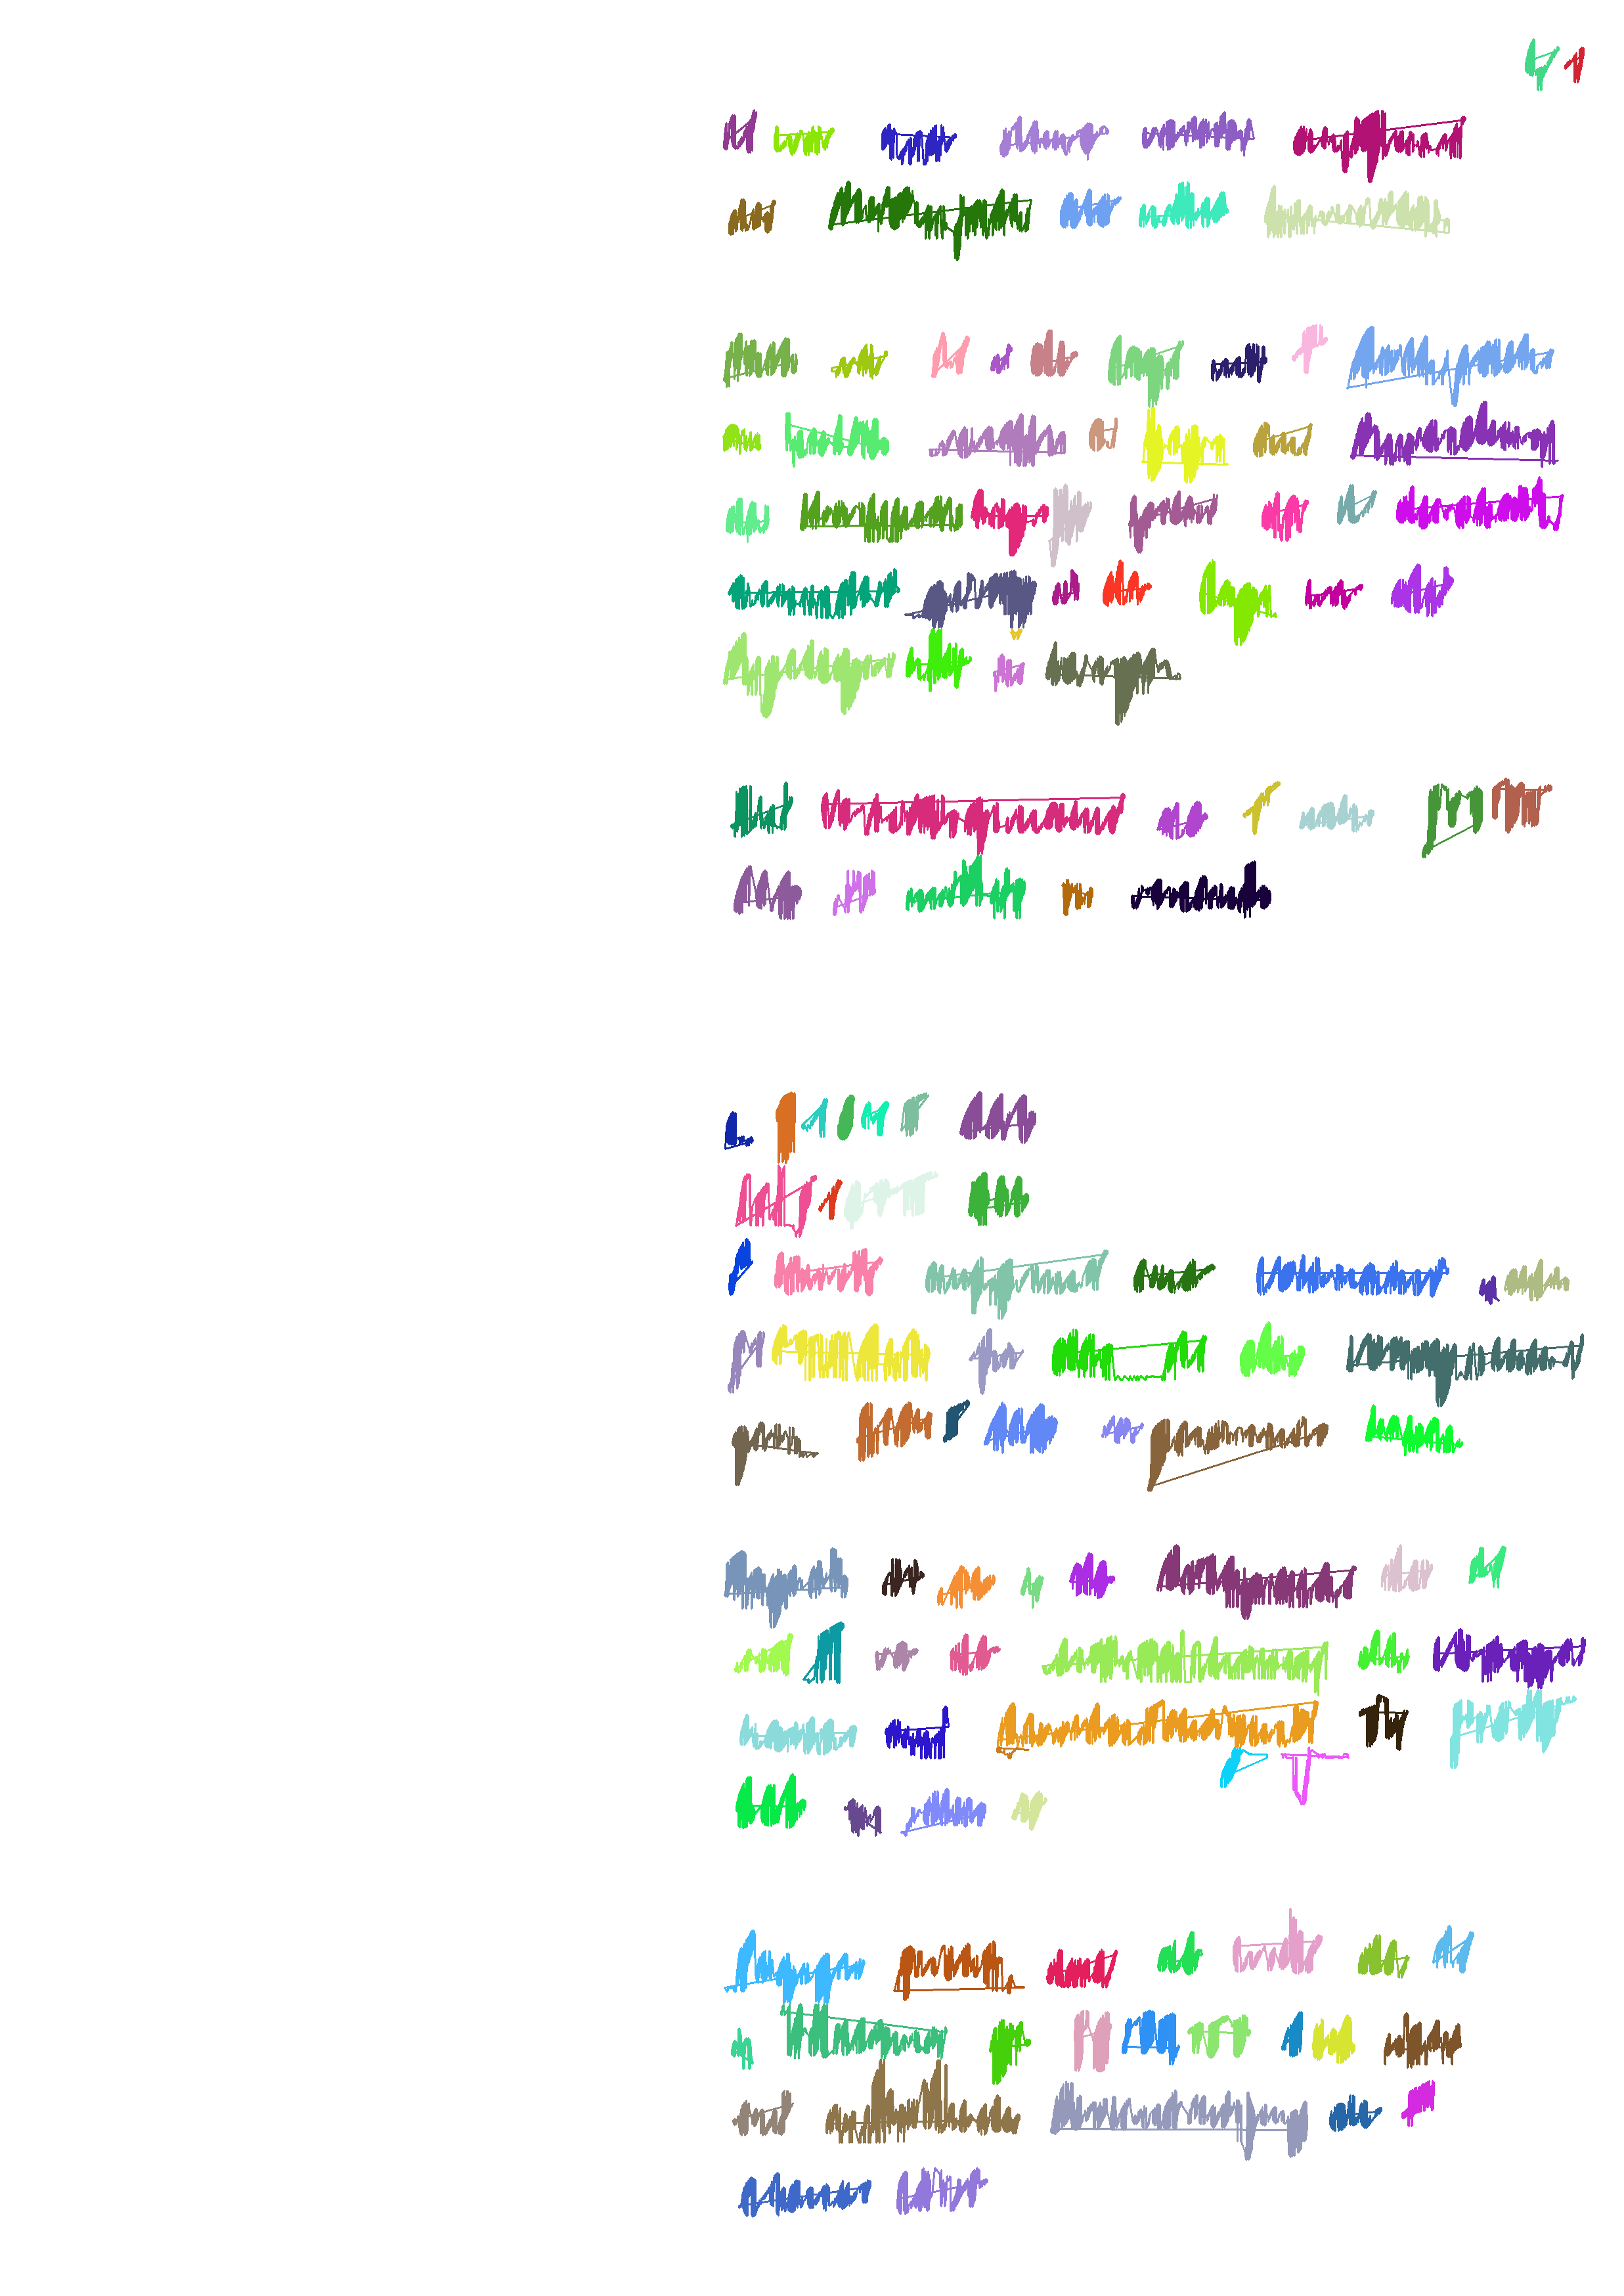

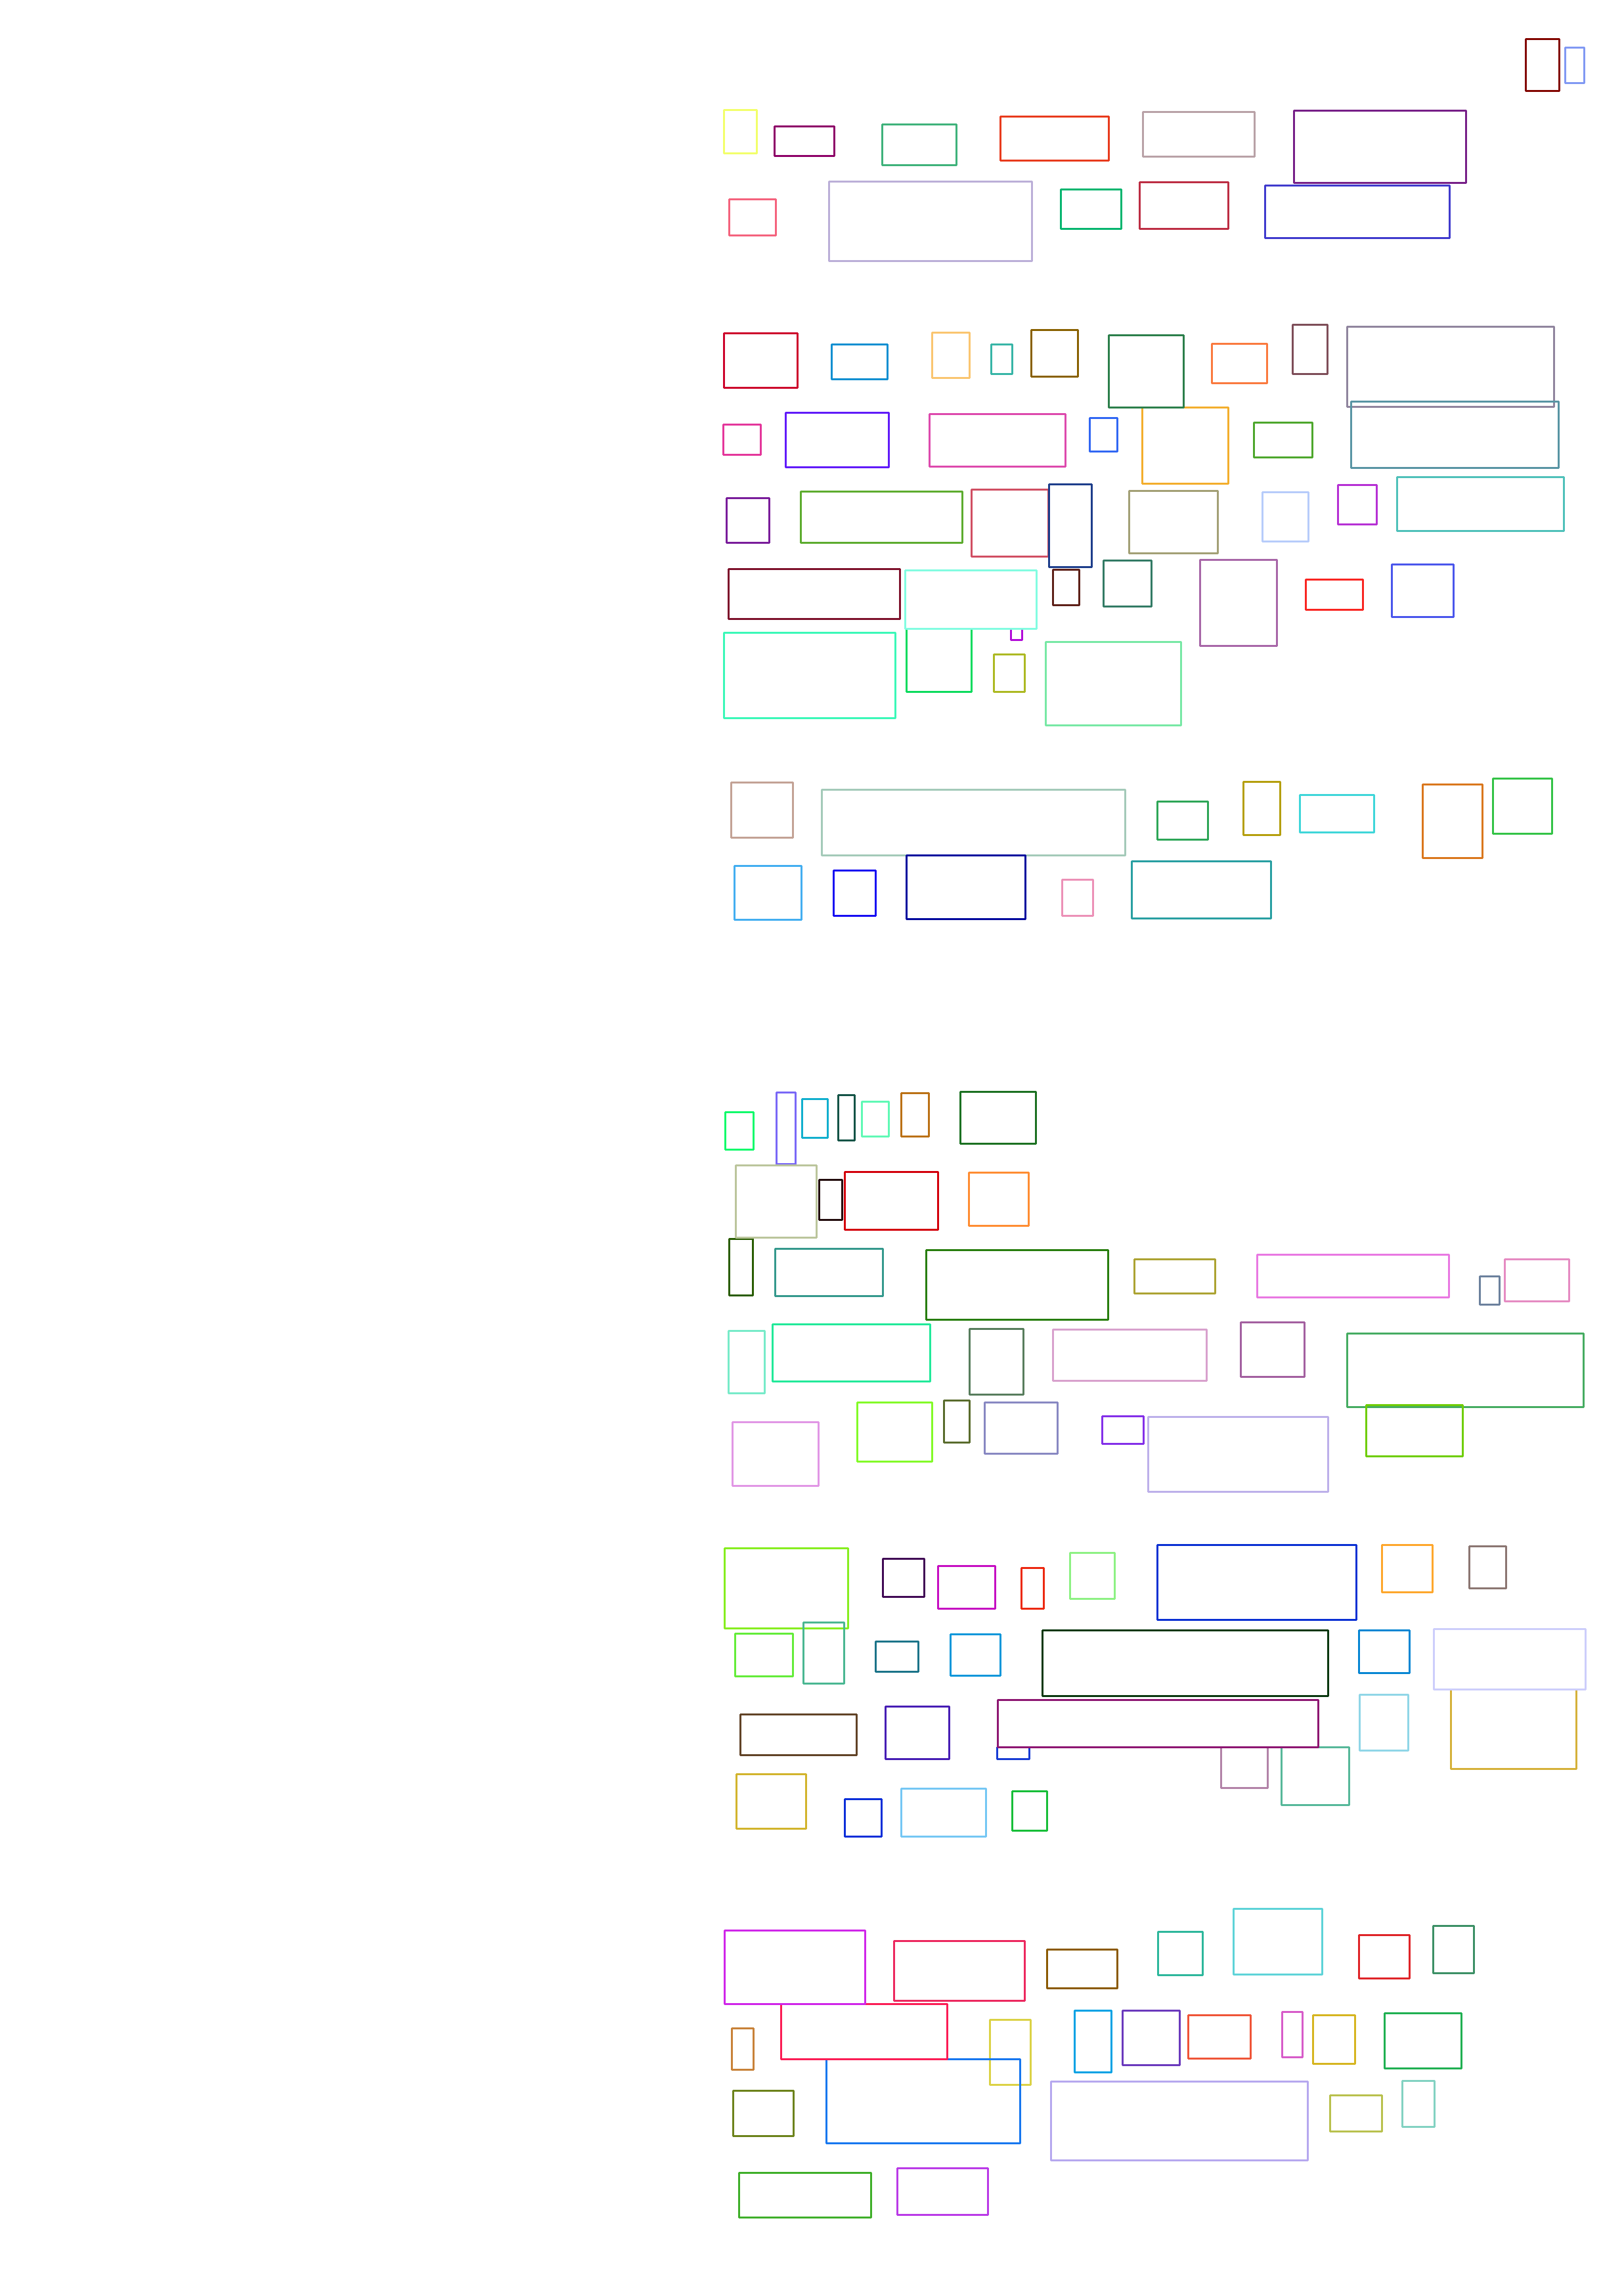

In [89]:
imagepdfconverter = ImagePDFConverter()
imagefilemanager = ImageFileManager()
imageprocessor = ImageProcessor()
contourmanager = ContourManager()
clusterconverter = ClusterConverter()
clusterextractor = ClusterExtractor()
clusteringalgorithmmanager = ClusteringalgorithmManager()
imagepresenter = ImagePresenter()
wordpositionfinder = WordPositionFinder(imagepdfconverter,imagefilemanager,imageprocessor,contourmanager,clusterconverter,clusterextractor,clusteringalgorithmmanager,imagepresenter)
contours = wordpositionfinder.utilize_wordpositionfinder(image)

In [90]:
contourimager = ContourImager()
for contour in contours:
  contourimager.convert_contour_to_image(image,contour)

